# Data Aquisition



In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install idx2numpy --quiet
# !pip install tensorflow --quiet
%pip install idx2numpy --quiet
%pip install tensorflow --quiet

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import requests
import zipfile
import gzip
import shutil
import idx2numpy
import numpy as np

dataset_dir = "/content/EMNIST"
os.makedirs(dataset_dir, exist_ok=True)

zip_path = os.path.join(dataset_dir, "gzip.zip")

# Download the EMNIST dataset zip if not present
if not os.path.exists(zip_path):
    print("Downloading EMNIST dataset...")
    url = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
    response = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(response.content)
    print("Download complete!")

# Extract the main zip
gzip_dir = os.path.join(dataset_dir, "gzip")
if not os.path.exists(gzip_dir):
    print("Extracting gzip.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(gzip_dir)
    print("Extraction complete!")

# Recursively decompress all .gz files
for root, dirs, files in os.walk(gzip_dir):
    for file in files:
        if file.endswith(".gz"):
            gz_path = os.path.join(root, file)
            out_path = os.path.join(root, file[:-3])
            if not os.path.exists(out_path):
                print(f"Decompressing {gz_path} ...")
                with gzip.open(gz_path, 'rb') as f_in:
                    with open(out_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
print("All .gz files decompressed!")

Download complete!
Extracting gzip.zip...
Extraction complete!
Decompressing /content/EMNIST\gzip\gzip\emnist-balanced-test-images-idx3-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-balanced-test-labels-idx1-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-balanced-train-images-idx3-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-balanced-train-labels-idx1-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-byclass-test-images-idx3-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-byclass-test-labels-idx1-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-byclass-train-images-idx3-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-byclass-train-labels-idx1-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-bymerge-test-images-idx3-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-bymerge-test-labels-idx1-ubyte.gz ...
Decompressing /content/EMNIST\gzip\gzip\emnist-bymerge-train-images-idx3-ubyte.

In [4]:
import idx2numpy
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Paths
train_images_path = os.path.join(gzip_dir, "gzip/emnist-balanced-train-images-idx3-ubyte")
train_labels_path = os.path.join(gzip_dir, "gzip/emnist-balanced-train-labels-idx1-ubyte")
test_images_path  = os.path.join(gzip_dir, "gzip/emnist-balanced-test-images-idx3-ubyte")
test_labels_path  = os.path.join(gzip_dir, "gzip/emnist-balanced-test-labels-idx1-ubyte")
balanced_mapping_path = os.path.join(gzip_dir, "gzip/emnist-balanced-mapping.txt")
# train_images_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-train-images-idx3-ubyte"
# train_labels_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-train-labels-idx1-ubyte"
# test_images_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-test-images-idx3-ubyte"
# test_labels_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-test-labels-idx1-ubyte"
# balanced_mapping_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-mapping.txt"
# train_images_path = r"gzip/emnist-balanced-train-images-idx3-ubyte"
# train_labels_path = r"gzip/emnist-balanced-train-labels-idx1-ubyte"
# test_images_path = r"gzip/emnist-balanced-test-images-idx3-ubyte"
# test_labels_path = r"gzip/emnist-balanced-test-labels-idx1-ubyte"
# balanced_mapping_path = r"gzip/emnist-balanced-mapping.txt"

# Load data
x_train = idx2numpy.convert_from_file(train_images_path)
y_train = idx2numpy.convert_from_file(train_labels_path)
x_test = idx2numpy.convert_from_file(test_images_path)
y_test = idx2numpy.convert_from_file(test_labels_path)

mapping = {}
with open(balanced_mapping_path, 'r') as f:
    for line in f:
        label, ascii_code = line.strip().split()
        mapping[int(label)] = chr(int(ascii_code))

y_train_chars = np.array([mapping[label] for label in y_train])
y_test_chars = np.array([mapping[label] for label in y_test])

# Preprocessing

In [5]:
from tensorflow.keras.utils import to_categorical

# Normalize and reshape
x_train_nn = x_train / 255.0
x_test_nn = x_test / 255.0
x_train_nn = x_train_nn.reshape(-1, 28, 28, 1)
x_test_nn = x_test_nn.reshape(-1, 28, 28, 1)

def fix_rotation(x):
    # EMNIST images need to be rotated -90 degrees and flipped horizontally
    return np.fliplr(np.rot90(x, k=1, axes=(1, 2)))

x_train_nn = fix_rotation(x_train_nn)
x_test_nn = fix_rotation(x_test_nn)

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Train shape:", x_train_nn.shape)
print("Test shape:", x_test_nn.shape)


Train shape: (112800, 28, 28, 1)
Test shape: (18800, 28, 28, 1)


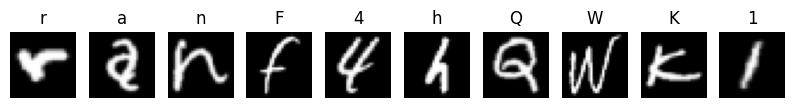

In [6]:
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train_nn[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(y_train_chars[i])
plt.show()  #just to see the preprocessed images


# Baseline Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,807 (897.68 KB)

 Trainable params: 229,807 (897.68 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
import json

early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop if no improvement for 3 epochs
    restore_best_weights=True
)

history = model.fit(x_train_nn, y_train_cat,
                    epochs=50, batch_size=128,
                    validation_data=(x_test_nn, y_test_cat),
                    callbacks=[early_stopping])

with open('baseline_training_history.json', 'w') as f:
    json.dump(history.history, f)


Epoch 1/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 94s 105ms/step - accuracy: 0.4681 - loss: 1.9071 - val_accuracy: 0.8255 - val_loss: 0.5414
Epoch 2/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 89s 101ms/step - accuracy: 0.7652 - loss: 0.7308 - val_accuracy: 0.8440 - val_loss: 0.4626
Epoch 3/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 90s 102ms/step - accuracy: 0.7985 - loss: 0.6152 - val_accuracy: 0.8516 - val_loss: 0.4301
Epoch 4/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 140s 99ms/step - accuracy: 0.8193 - loss: 0.5481 - val_accuracy: 0.8607 - val_loss: 0.4052
Epoch 5/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 88s 99ms/step - accuracy: 0.8311 - loss: 0.5012 - val_accuracy: 0.8644 - val_loss: 0.3909
Epoch 6/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 142s 100ms/step - accuracy: 0.8389 - loss: 0.4727 - val_accuracy: 0.8700 - val_loss: 0.3787
Epoch 7/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.8467 - loss: 0.4450 - val_accuracy: 0.8736 - val_loss: 0.3765
Epoch 8/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 89s 101ms/step - accuracy: 0.8493 - loss: 0

In [14]:
model.save('emnist_baseline_model.keras')

In [15]:
from tensorflow.keras.models import load_model

baseline_model = load_model('emnist_baseline_model.keras')

y_pred = np.argmax(baseline_model.predict(x_test_nn), axis=1)
y_pred_chars = np.array([mapping[label] for label in y_pred])
y_true_chars = np.array([mapping[label] for label in y_test])
print(classification_report(y_true_chars, y_pred_chars))

# Get overall accuracy
accuracy = accuracy_score(y_true_chars, y_pred_chars)
print(f"Accuracy: {accuracy:.4f}")

# Get macro/micro F1-score
f1_macro = f1_score(y_true_chars, y_pred_chars, average='macro')
f1_micro = f1_score(y_true_chars, y_pred_chars, average='micro')

print(f"F1 (Macro): {f1_macro:.4f}")
print(f"F1 (Micro): {f1_micro:.4f}")

588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       400
           1       0.52      0.81      0.63       400
           2       0.92      0.85      0.88       400
           3       0.98      0.98      0.98       400
           4       0.91      0.92      0.92       400
           5       0.94      0.90      0.92       400
           6       0.93      0.94      0.94       400
           7       0.97      0.99      0.98       400
           8       0.93      0.92      0.93       400
           9       0.66      0.86      0.74       400
           A       0.97      0.95      0.96       400
           B       0.96      0.96      0.96       400
           C       0.94      0.97      0.95       400
           D       0.93      0.90      0.92       400
           E       0.97      0.97      0.97       400
           F       0.64      0.58      0.61       400
           G       0.91      0.95      0

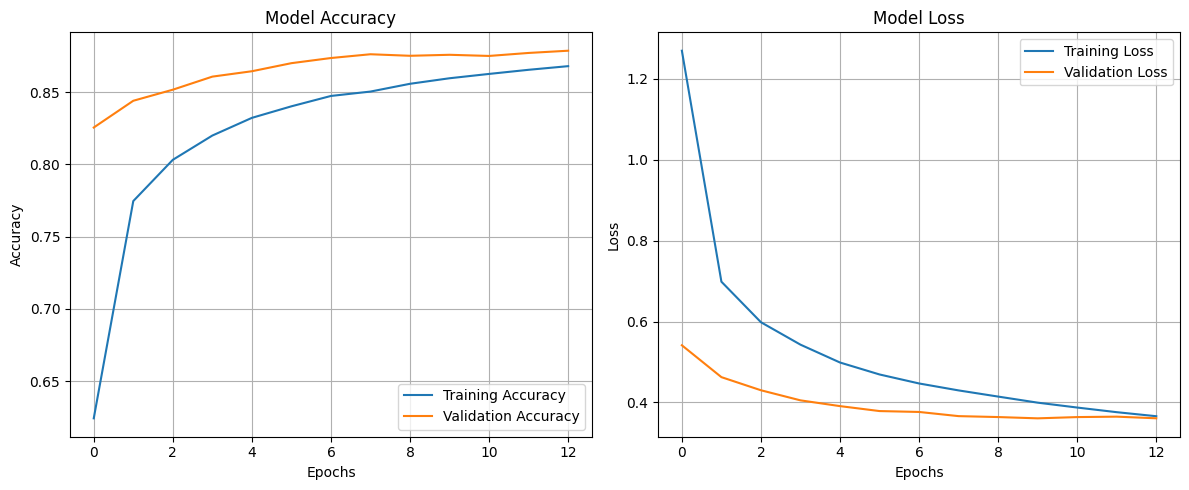

In [16]:
with open('baseline_training_history.json', 'r') as f:
    baseline_history = json.load(f)

plt.figure(figsize=(12,5))

# Accuracy graph
plt.subplot(1,2,1)
plt.plot(baseline_history['accuracy'], label='Training Accuracy')
plt.plot(baseline_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss graph
plt.subplot(1,2,2)
plt.plot(baseline_history['loss'], label='Training Loss')
plt.plot(baseline_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

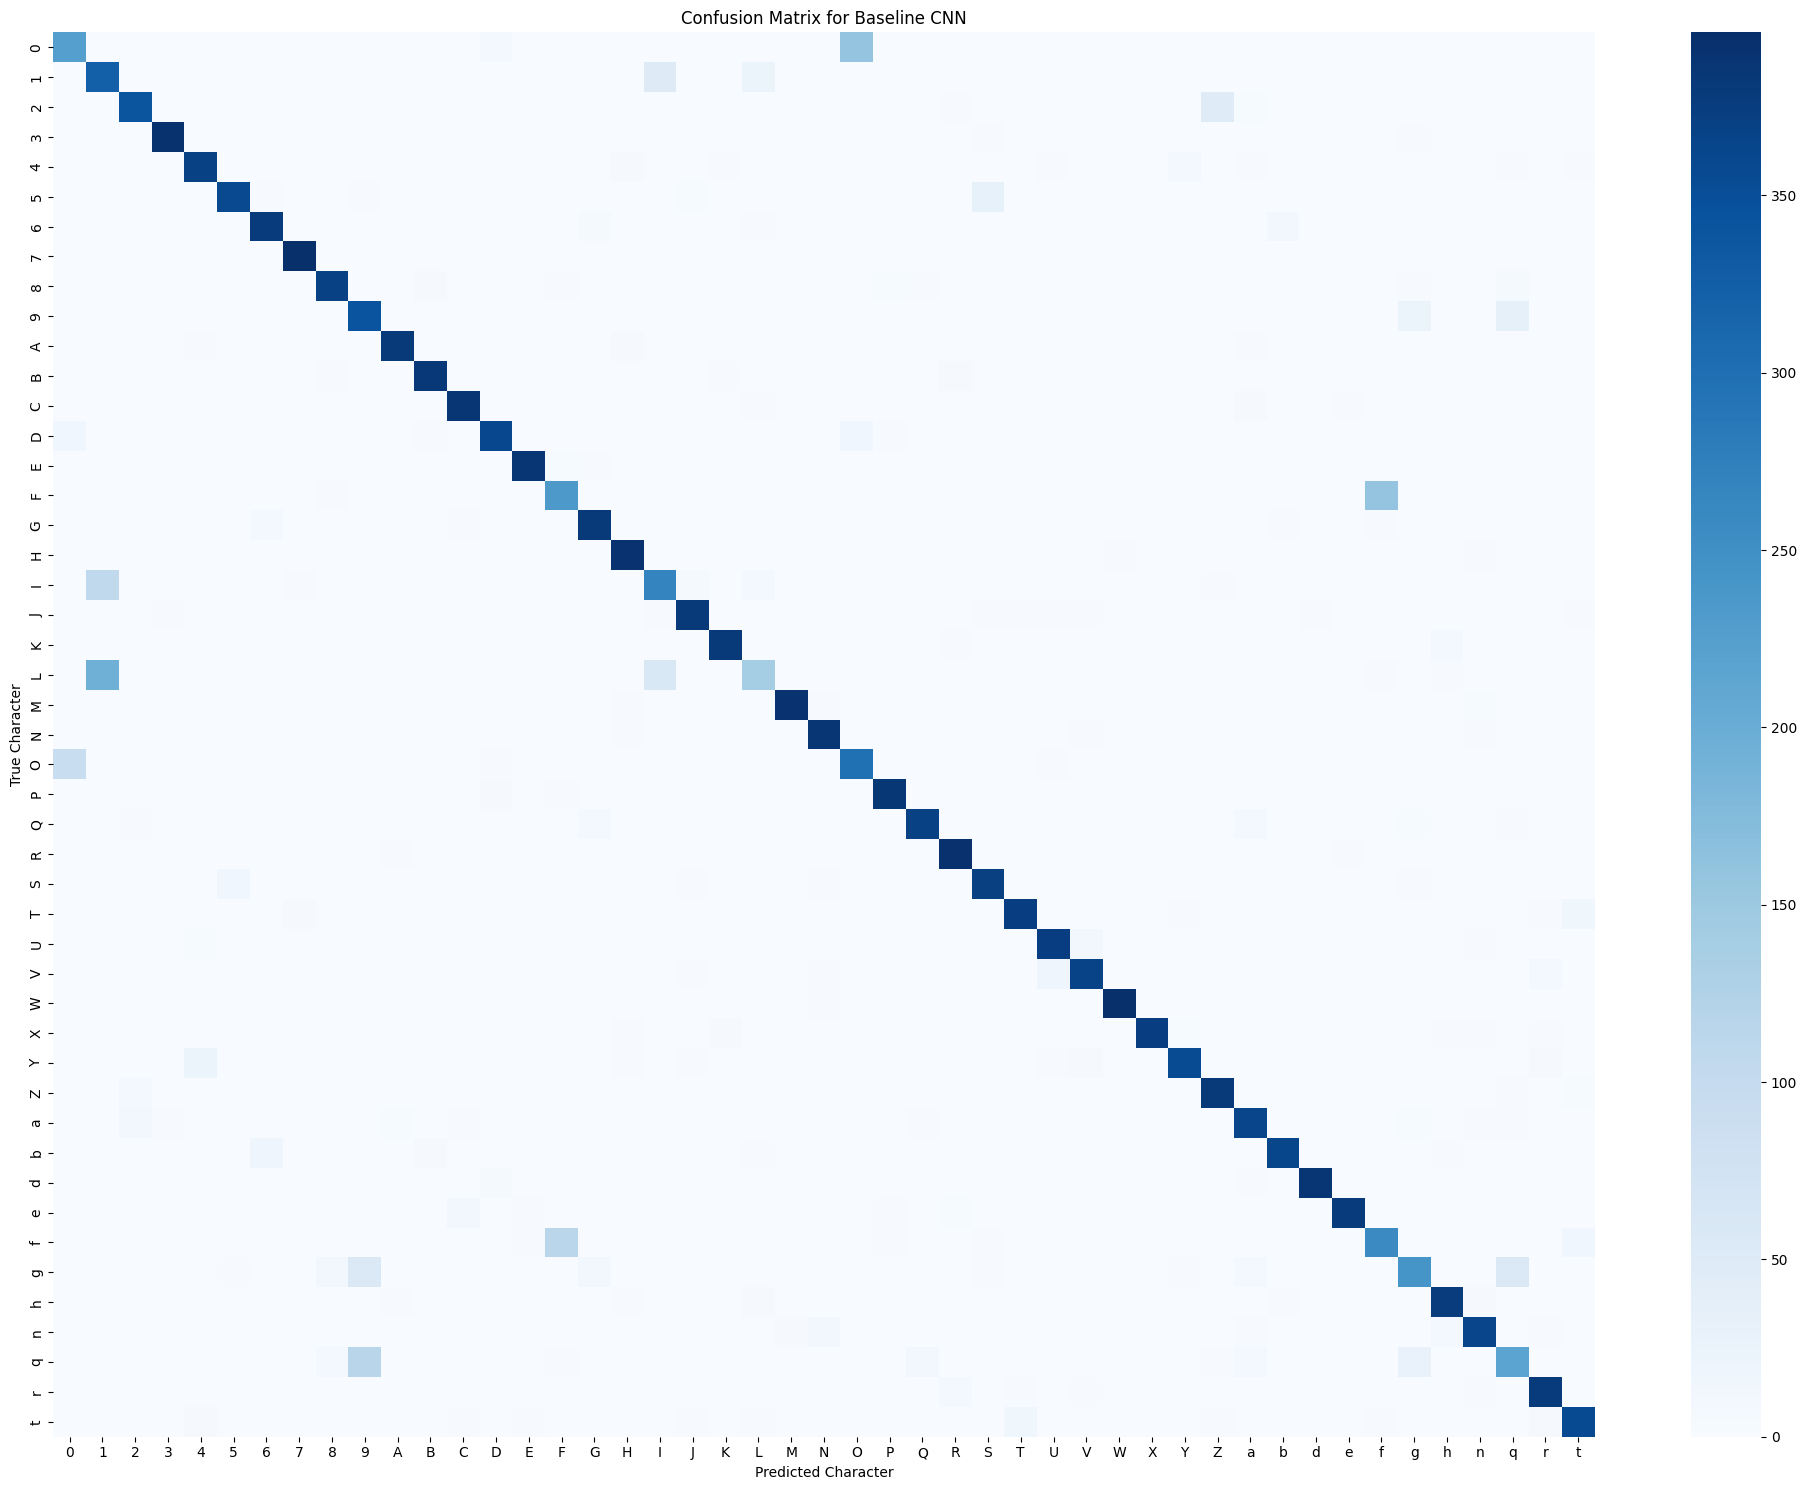

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_chars, y_pred_chars)
plt.figure(figsize=(20,15))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=sorted(list(set(y_true_chars))),
            yticklabels=sorted(list(set(y_true_chars))))
plt.xlabel('Predicted Character')
plt.ylabel('True Character')
plt.title('Confusion Matrix for Baseline CNN')
plt.tight_layout()
plt.show()

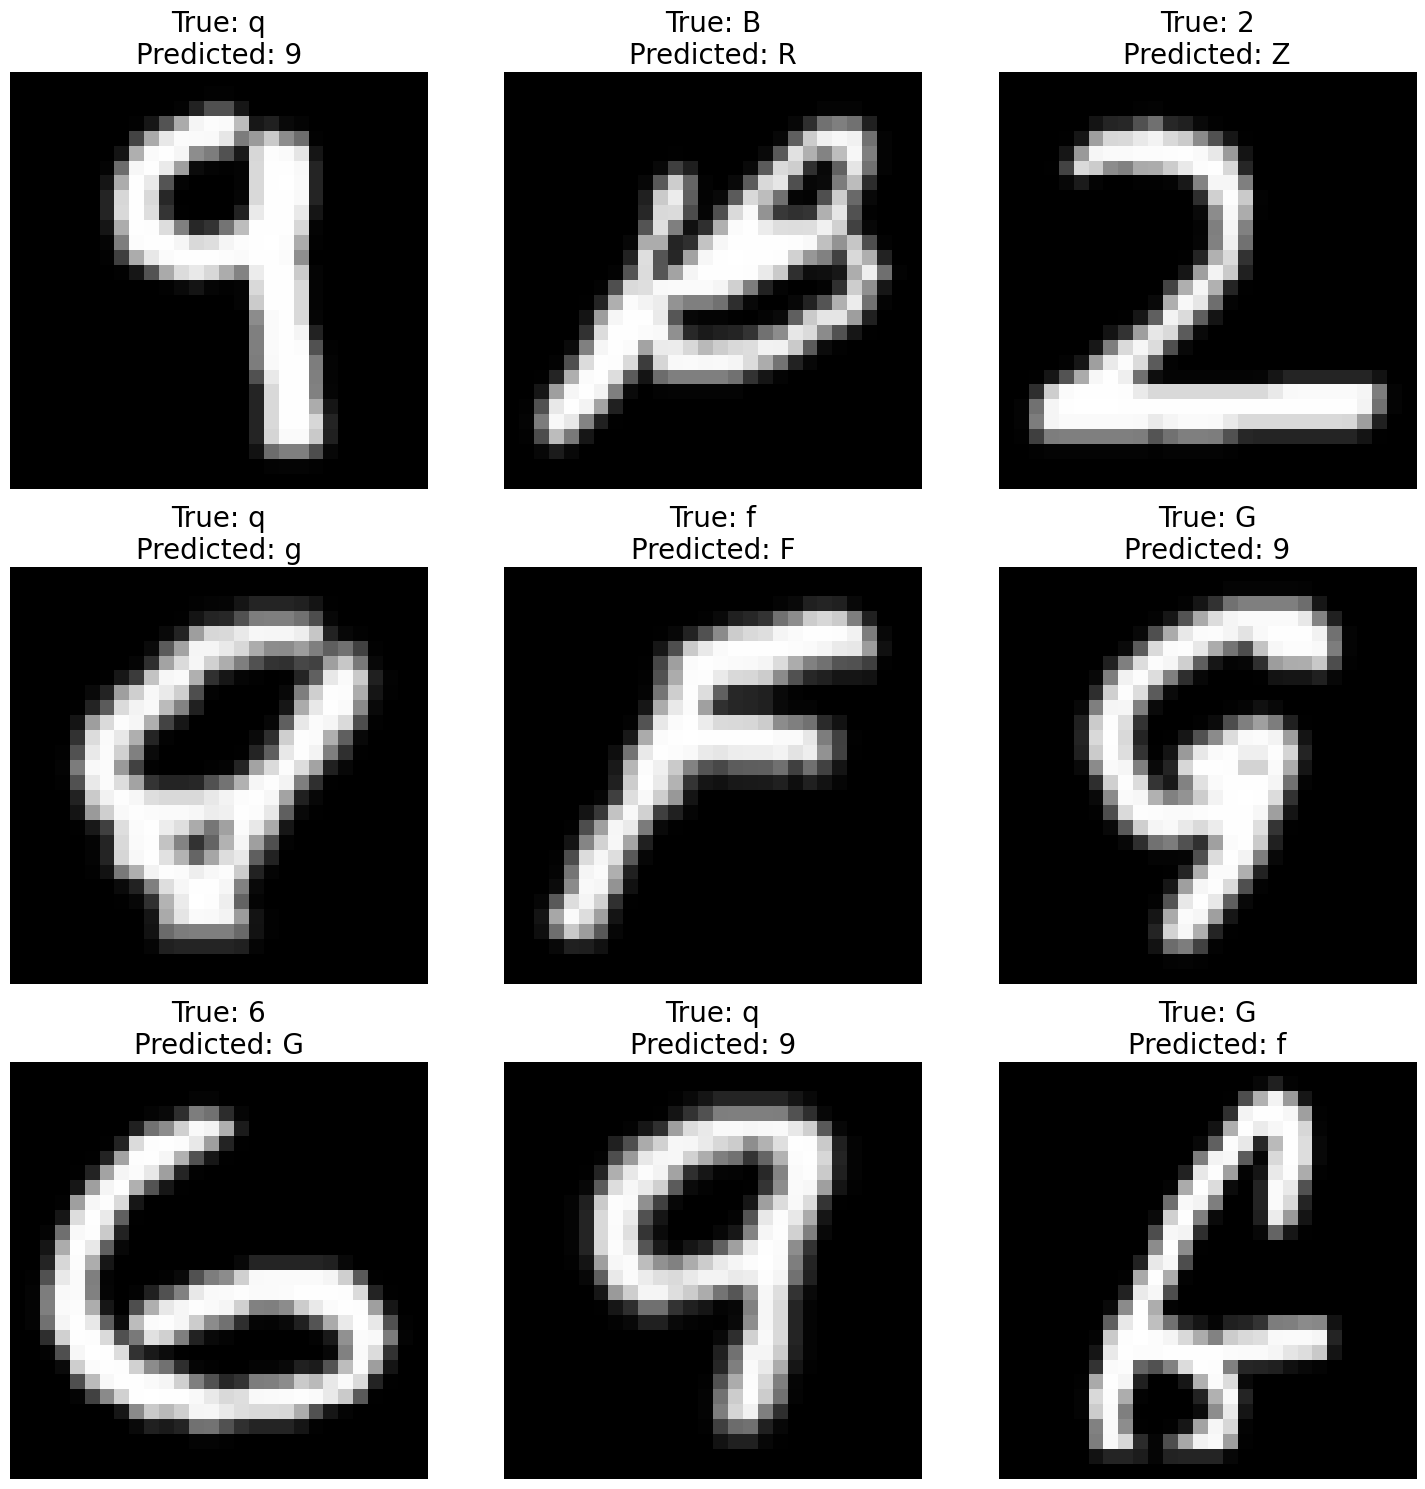

In [18]:
misclassified_indices = np.where(y_pred_chars != y_true_chars)[0]

# Number of misclassified images to display
num_to_show = 9
plt.figure(figsize=(15, 15))

for i, index in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_nn[index].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_true_chars[index]}\nPredicted: {y_pred_chars[index]}",fontdict={'fontsize':20})
    plt.axis('off')

plt.tight_layout()
plt.show()

# + Data Augmentation  (run after data aquisition and preprocessing)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,      # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,         # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
)

datagen.fit(x_train_nn)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,807 (897.68 KB)

 Trainable params: 229,807 (897.68 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
import json

early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop if no improvement for 3 epochs
    restore_best_weights=True
)

history = model.fit(
    datagen.flow(x_train_nn, y_train_cat, batch_size=128),
    epochs=50,
    validation_data=(x_test_nn, y_test_cat),
    callbacks=[early_stopping]
)

with open('baseline+data_augmentation_training_history.json', 'w') as f:
    json.dump(history.history, f)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


882/882 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.3554 - loss: 2.3447 - val_accuracy: 0.8168 - val_loss: 0.5684
Epoch 2/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.6751 - loss: 1.0435 - val_accuracy: 0.8412 - val_loss: 0.4807
Epoch 3/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.7270 - loss: 0.8541 - val_accuracy: 0.8557 - val_loss: 0.4288
Epoch 4/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.7540 - loss: 0.7624 - val_accuracy: 0.8572 - val_loss: 0.4230
Epoch 5/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.7712 - loss: 0.7080 - val_accuracy: 0.8629 - val_loss: 0.4090
Epoch 6/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.7843 - loss: 0.6593 - val_accuracy: 0.8625 - val_loss: 0.3999
Epoch 7/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.7948 - loss: 0.6258 - val_accuracy: 0.8690 - val_loss: 0.3870
Epoch 8/50
882/882 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.7982 - loss: 0.6124 - val_accurac

In [19]:
model.save('emnist_data_augmentation.keras')

In [20]:
model = load_model('emnist_data_augmentation.keras')

y_pred = np.argmax(model.predict(x_test_nn), axis=1)
y_pred_chars = np.array([mapping[label] for label in y_pred])
y_true_chars = np.array([mapping[label] for label in y_test])
print(classification_report(y_true_chars, y_pred_chars))

# Get overall accuracy
accuracy = accuracy_score(y_true_chars, y_pred_chars)
print(f"Accuracy: {accuracy:.4f}")

# Get macro/micro F1-score
f1_macro = f1_score(y_true_chars, y_pred_chars, average='macro')
f1_micro = f1_score(y_true_chars, y_pred_chars, average='micro')

print(f"F1 (Macro): {f1_macro:.4f}")
print(f"F1 (Micro): {f1_micro:.4f}")

588/588 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.68      0.70      0.69       400
           1       0.49      0.77      0.59       400
           2       0.94      0.81      0.87       400
           3       0.99      0.98      0.99       400
           4       0.90      0.96      0.93       400
           5       0.89      0.94      0.92       400
           6       0.94      0.95      0.95       400
           7       0.97      0.98      0.98       400
           8       0.93      0.95      0.94       400
           9       0.65      0.88      0.75       400
           A       0.96      0.99      0.97       400
           B       0.94      0.98      0.96       400
           C       0.97      0.96      0.97       400
           D       0.92      0.94      0.93       400
           E       0.98      0.99      0.98       400
           F       0.67      0.59      0.63       400
           G       0.93      0.95      0

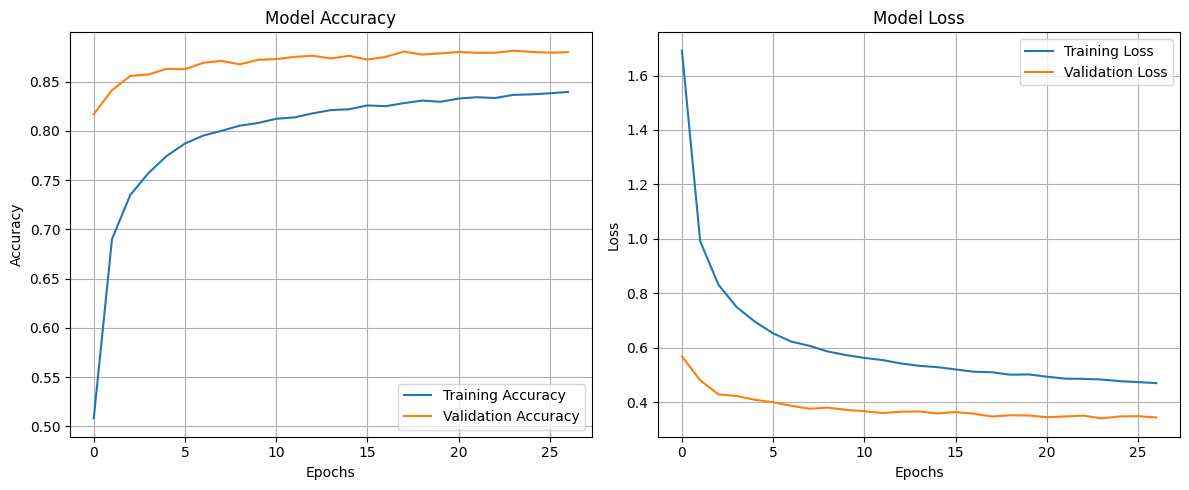

In [21]:
with open('baseline+data_augmentation_training_history.json', 'r') as f:
    history = json.load(f)

plt.figure(figsize=(12,5))

# Accuracy graph
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss graph
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

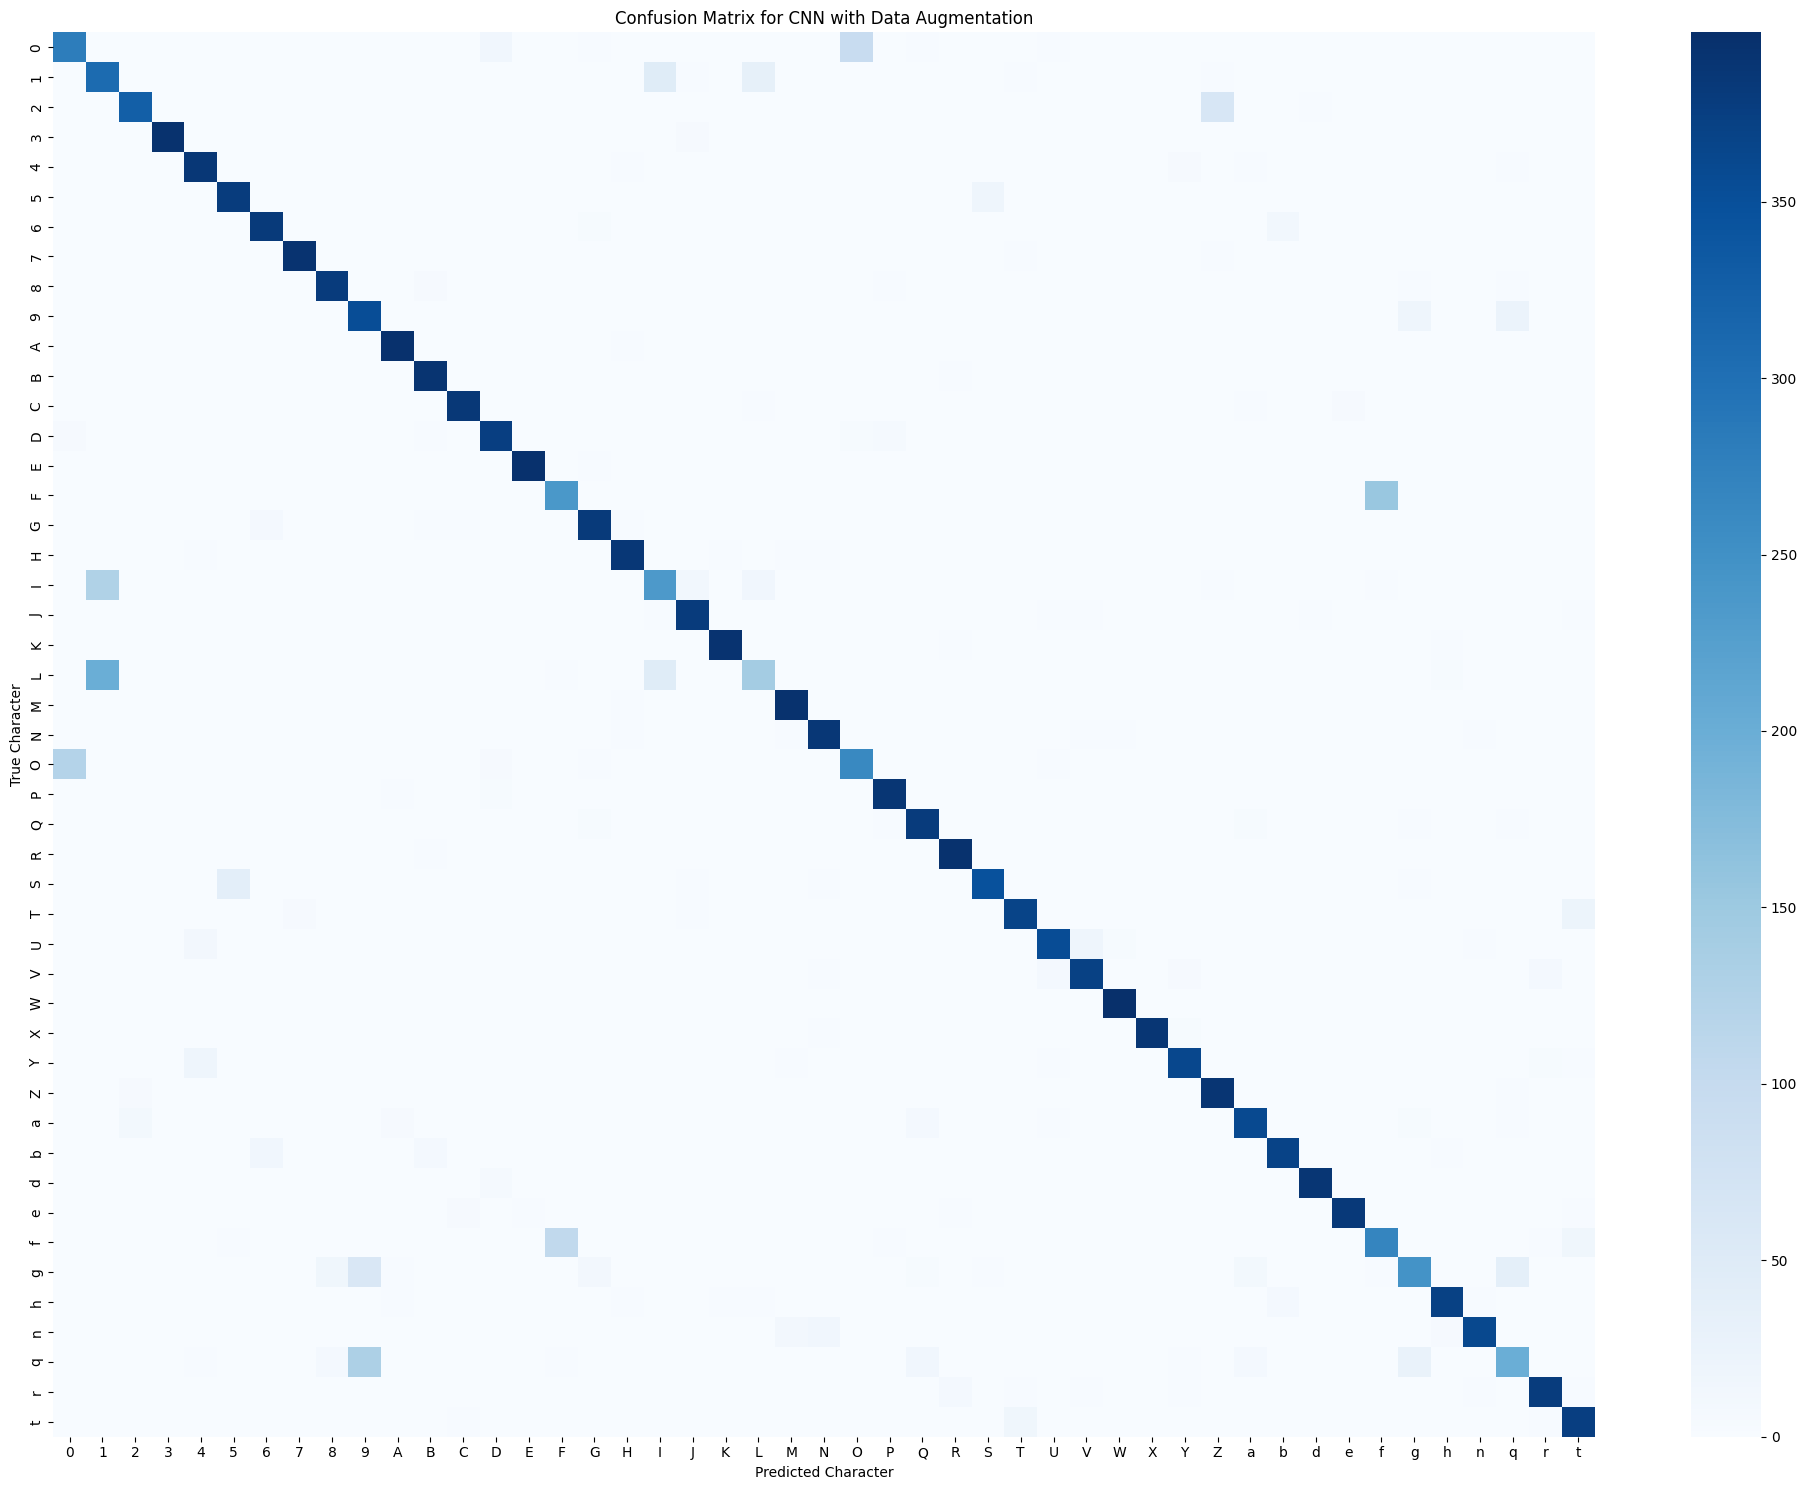

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_chars, y_pred_chars)
plt.figure(figsize=(20,15))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=sorted(list(set(y_true_chars))),
            yticklabels=sorted(list(set(y_true_chars))))
plt.xlabel('Predicted Character')
plt.ylabel('True Character')
plt.title('Confusion Matrix for CNN with Data Augmentation')
plt.tight_layout()
plt.show()